V tomto příkladu budeme pracovat s Bibliografií českého literárního exilu, která obsahuje záznamy o knihách a statích s literární tématikou, vydaných a publikovaných v českých exilových nakladatelstvích a časopisech. Nás budou zajímat pouze záznamy o statích, u kterých jsou uvedeny časopis a místo vydání. Ty najdeme v poli 773 \$t. Ukážeme si, jak z dat získat a upravit místo vydání záznamu, zjistit jeho souřadnice a následně místo zobrazit na mapě.

#### Příprava 
Jako první si musíme nainstalovat knihovny, se kterými budeme pracovat. Knihovny jsou balíčky funkcí, které nejsou součástí základu jazyka python. <br>
Knihovny nainstalujeme pomocí příkazu %pip install jmeno_knihovny. Pak je do našeho notebooku přidáme pomocí příkazu import jmeno_knihovny (as alias). K funkcím knihovny se pak přistupuje jmeno_knihovny.jmeno_funkce <br> 
Pokud z knihovny chceme využít pouze jednu funkci, přidáme ji pomocí from jmeno_knihovny import jmeno_funkce


In [35]:
%pip install geopandas
%pip install matplotlib
%pip install numpy 
%pip install pandas
%pip install requests
%pip install shapely

from collections import Counter
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import re
import requests
from shapely.geometry import Point
from statistics import median, mean

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Načtení dat

Nejprve načteme naše uložená csv data. Jak převést marcovou databázi do csv tabulky a pak csv tabulku načíst jsme si ukázali v předchozím příkladu. Csv tabulku z markové databáze lze vygenerovat i pomocí skriptu save_csv.py.

In [18]:
# Cesta k nasim datum
csv_data = 'data/csv/out_cle.csv'

# Nacteni dat
df = pd.read_csv(csv_data, delimiter=',')

for column in df.columns:
    if df[column].dtype != 'int64':   
        # Hodnoty spojene v jeden string zpatky rozdelime do listu, aby se nam s nim lepe pracovalo
        df[column] = df[column].apply(lambda x: x.split(';') if isinstance(x, str)  else [])


Podíváme se, kolik záznamů u sebe má napsaný časopis. Tyto záznamy nás budou zajímat a budeme je považovat za záznamy o statích. Zbytek budeme považovat za záznamy o knihách.
###### Pokud bychom chtěli přesná data, v marcovém záznamu je kolonka LDR (leader), která nese informaci o typu záznamu. 

In [19]:
# Spocteme radky, ktere v maji nejakou  hodnotu
magazines_counts = df['magazine'].apply(lambda x: 1 if len(x) > 0 else 0)

sum_magazines_counts = magazines_counts.sum()

print("Počet záznamů o statích: ", sum_magazines_counts)

sum_books_counts = len(df) - sum_magazines_counts

print("Počet záznamů o knihách: ", sum_books_counts)

# Vypise prvnich 5 zaznamu v DataFramu
print(df.head())
print("----------------------------------------------------------------------------------------------------")

# Vypise poslednich 5 zaznamu v DataFramu
print(df.tail())

Počet záznamů o statích:  7953
Počet záznamů o knihách:  1659
                                  title               author      author code  \
0                [Kultura je když... /]  [Kliment, Alexandr]     [jk01060558]   
1                       [Hra o život /]   [Dobrovský, Luboš]  [jn20000400479]   
2          [Památce Bohuslava Reynka /]    [Jirousová, Věra]  [jn19990218035]   
3           [Joyceův zkušební návrat /]    [Urbánek, Zdeněk]     [jk01140872]   
4  [Čas jako trvání a jako prázdnota /]      [Černý, Václav]     [jk01021636]   

   year             figures             description     genre    magazine  
0  1978                  []              [estetika]   [úvahy]  [Spektrum]  
1  1978    [Kundera, Milan]           [česká próza]  [studie]  [Spektrum]  
2  1978  [Reynek, Bohuslav]     [čeští spisovatelé]  [studie]  [Spektrum]  
3  1978      [Joyce, James]  [anglicky psané drama]  [studie]  [Spektrum]  
4  1979                  []              [estetika]   [eseje]  [Spektru

Jak vidíme, statě tvoří většinu databáze.<br>
Vypsali jsme si i začátek a konec našeho DataFramu. Můžeme si všimnout, že u jména časopisu je v kulatých závorkách napsané místo vydání, a že není napsáno u všech. 

#### Extrahování místa vydání

Vyextrahujeme si tedy místo vydání a zjisíme, kolik záznamů nemá místo vydání. K tomu využijeme regulární výraz, který nám najde řetězec (slovo) v kulatých závorkách. Záznamy, které mají časopis, ale ne místo vydání, budou vracet hodnotu None. 

In [20]:
# regex patern, ktery najde substring mezi zavorkami
pattern_cities = r"\((.*?)\)"

# Ulozime mesta do promenne
cities = df['magazine'].apply(lambda x: [re.search(pattern_cities, y).group(1) if re.search(pattern_cities, y) else None for y in x]).tolist().copy()

# Spocteme vsechny hodnoty, ktere v sobe maji None hodnotu, a tedy nemaji misto vydani
sum_None =  sum(list(map(lambda x : 1 if (len(x) == 1 and x[0] is None) else 0, cities )))

print("Počet časopisů bez místa vydání: ", sum_None)

Počet časopisů bez místa vydání:  41


Jak vidíme, není to příliš mnoho záznamů, a proto se jimi nemusíme trápit. <br>

Teď už nám jen zbývá zjistit místa vydání a jejich četnost výskytů. <br> 

Abychom nemuseli psát stejný kód několikrát, napíšeme ho jednou do funkce, kterou pak jednoduše zavoláme. V tomto případě si napíšeme funkci, která nám z několika listů (seznamů) vnořených do sebe vytvoří jeden. To se nám bude hodit, až budeme chtít spočítat četnost výskytů míst vydání. 

In [21]:
# Funkce na "zplosteni" listu -> ze sloupce DataFramu vytvori jeden list se vsemi elementy 
def flatten_list(strings):
    flattened_list = []
    if strings is not None: # Zkontrolujeme, jestli element neni None
        for item in strings:
            if isinstance(item, str):  # Pokud je element string, pridame ho do seznamu
                flattened_list.append(item)
            elif isinstance(item, list):  # Rekurzivne zavola sebe
                flattened_list.extend(flatten_list(item))
        return flattened_list

In [22]:
# Vytvorime zplostely list, ktery i odstrani None hodnoty
cities = flatten_list(cities)

print("\nUnikátní hodnoty:", np.unique(cities))



Unikátní hodnoty: ['Curych' 'Edmonton' 'Hamburg' 'Kolín nad Rýnem' 'Köln-Ehrenfeld' 'London'
 'London, Index on Censorship' 'Londýn' 'Mnichov' 'New York'
 'New York-Paříž' 'Norman, Oklahoma' 'Rotterdam' 'Scheinfeld' 'St. Gallen'
 'Toronto' 'Vídeň' 'Winterthur-Obstladen' 'Wintertuhr-Obstladen'
 'Wuppertal' 'Řím' 'Ženeva-Middlesex-Mnichov']


#### Čistění dat

Z uniktních hodnot vidíme, že některá města tam jsou jak pod svým původím jménem, tak pod svou českou alternativou (London - Londýn, Köln - Kolín nad Rýnem). U některých jsou překlepy (Wintertuhr-Obstladen -> Winterthur-Obstalden), které musíme opravit. U některých je zase měst více (Wintertuhr-Obstladen , Ženeva-Middlesex-Mnichov). V tomto  případě si všechna města uložíme v seznamu.


In [23]:
# Odstranime Index on Censorship z elementu "London, Index on Censorship" a spojime "London" a "Londýn"
cities = list(map(lambda x: 'Londýn' if 'London' in x else x, cities))

# Odstranime 'Obstladen' z Winterthur
cities = list(map(lambda x: ['Winterthur', 'Obstalden'] if 'Obstladen' in x else x, cities))

# Vytvorime dva elementy z New York-Paříž
cities = list(map(lambda x: ['New York','Paříž'] if 'New York-Paříž' in x else x, cities))

# Vytvorime tri elementy z Ženeva-Middlesex-Mnichov
cities = list(map(lambda x: ['Ženeva','Middlesex', 'Mnichov'] if 'Ženeva-Middlesex-Mnichov' in x else x, cities))

# Prepiseme Köln-Ehrenfeld na Kolín nad Rýnem 
cities = list(map(lambda x: 'Kolín nad Rýnem' if 'Köln-Ehrenfeld' in x else x, cities))

# Zplostime seznam
cities = flatten_list(cities)

# Spocteme vyskyty mest
cities_number_of_records = Counter(cities)

print(cities_number_of_records)

# Vytvorime DataFrame 
cities_df = pd.DataFrame.from_dict(cities_number_of_records, orient='index').reset_index()

# Popiseme sloupce
cities_df.columns = ['city', 'number of records']

Counter({'Mnichov': 2197, 'New York': 2090, 'Řím': 1484, 'Paříž': 928, 'Winterthur': 511, 'Obstalden': 511, 'Hamburg': 428, 'Curych': 273, 'Toronto': 196, 'Rotterdam': 185, 'Wuppertal': 135, 'Kolín nad Rýnem': 120, 'Vídeň': 68, 'Londýn': 65, 'St. Gallen': 65, 'Ženeva': 53, 'Middlesex': 53, 'Edmonton': 39, 'Scheinfeld': 36, 'Norman, Oklahoma': 22})


#### Načtení souřadnic

Tento kód je ukázka toho, jak pomocí API získat souřadnice měst. Je k němu potřeba osobní API klíč, který lze zíkat z této stránky - https://opencagedata.com/api. Ten se jen přidá do proměnné api_key. Kód pak vyšle request přes url stránku s naším API klíčem a jménem města. Pokud request proběhne v pořádku, funkce vrátí zeměpisnou šířku (latitude) a výšku (longitude)<br>



###### Tato buňka se nespustí. Pro spuštění je potřeba vymazat první řádek `%%script echo skipping`


In [24]:
%%script echo skipping

# funkce, ktera podle jmena mesta najde jeho souradnice
def get_city_coordinates(city):
    api_key = "MY KEY"
    url = f"https://api.opencagedata.com/geocode/v1/json?q={city}&key={api_key}"
    
    # Volani funkce requests
    response = requests.get(url)
    # 
    data = response.json()
    
    if response.status_code == 200:
        # pokud se mesto podarilo najit, ulozime souradnice
        if data["total_results"] > 0:
            lat = data["results"][0]["geometry"]["lat"]
            lon = data["results"][0]["geometry"]["lng"]
            return lat, lon
        else:
            print("No results found for the city.")
    else:
        print("Error occurred while fetching data.")

Pomocí funkce get_city_coordinates, kterou jsme si napsali v předchozí buňce, zjistíme souřadnice měst, která si zapíšeme do DataFramu. Na konci se DataFrame uloží do csv souboru. 

###### Tato buňka se nespustí. Pro spuštění je potřeba vymazat první řádek `%%script echo skipping`


In [31]:
%%script echo skipping

cities_df['latitude'] = None
cities_df['longitude'] = None
df.reindex(columns=['city', 'number of records', 'lat', 'lon'], fill_value=0)

# Unikatni mesta 
unique_cities = np.unique(cities)
coordinates = {}

# Iterace pres vsechny unikatni mesta
for city in unique_cities:
    # Pouzijeme funkci try-except, ktera nam odchyti pripadne chyby
    try:
        (latitude, longitude) = get_city_coordinates(city)
        print(f"Coordinates of {city}: Latitude={latitude}, Longitude={longitude}")
        coordinates[city] = (latitude, longitude)
        cities_df.loc[cities_df['city'] == city, 'latitude'] = latitude
        cities_df.loc[cities_df['city'] == city, 'longitude'] = longitude
    except:
        print(f"City {city} not found.")
          
# Data ze slovniku dame do DataFramu
df_coordinates = pd.DataFrame.from_dict(coordinates)

# Tabulku transponuje 
df_coordinates = df_coordinates.T
df_coordinates.to_csv('data/coordinates.csv')

Coordinates of Curych: Latitude=47.3744489, Longitude=8.5410422
Coordinates of Edmonton: Latitude=53.5462055, Longitude=-113.491241
Coordinates of Hamburg: Latitude=53.550341, Longitude=10.000654
Coordinates of Kolín nad Rýnem: Latitude=50.938361, Longitude=6.959974
Coordinates of Londýn: Latitude=51.5073359, Longitude=-0.12765
Coordinates of Middlesex: Latitude=51.5460558, Longitude=-0.2537791
Coordinates of Mnichov: Latitude=48.1371079, Longitude=11.5753822
Coordinates of New York: Latitude=40.7127281, Longitude=-74.0060152
Coordinates of Norman, Oklahoma: Latitude=35.2225717, Longitude=-97.4394816
Coordinates of Obstalden: Latitude=47.1171128, Longitude=9.1504524
Coordinates of Paříž: Latitude=48.8588897, Longitude=2.320041
Coordinates of Rotterdam: Latitude=51.9244424, Longitude=4.47775
Coordinates of Scheinfeld: Latitude=49.6653406, Longitude=10.462567
Coordinates of St. Gallen: Latitude=47.425618, Longitude=9.3762397
Coordinates of Toronto: Latitude=43.6534817, Longitude=-79.3839

#### Souřadnice

Souřadnice měst načteme ze souboru coordinates.csv, kde je u každého města zeměpisná šířka (latitude) a výška (longitude).

In [39]:
# Nacteme souradnice ze souboru
df_coordinates = pd.read_csv('data/coordinates.csv')

# Prejmenujeme sloupce
df_coordinates.columns = ['city','latitude', 'longitude']

# Spojime tabulky dohromady
points_df = pd.merge(cities_df, df_coordinates)

#### Ohraničení mapy

Jelikož se všechna města nachází buď v Evropě nebo v severní Americe, můžeme mapu světa, kterou budeme vykrelovat, ohraničit. Ohraničení definujeme pomocí minimální a maximální zeměpisné výšky a šířky. Následně pak vyřadíme všechna města, která jsou mimo ohraničení. <br>
Můžeme si vyskoušet nastavení různé zeměpisné šířky a výšky. <br>
Např.  [-130, 15, 50, 80] je hranice severní Ameriky a Evropy. [-5, 35, 30, 55] je přibližné ohraničení Evropy. [6, 45, 11, 48] je přibližně Švýcarská hranice. <br>



In [41]:
# Hranice, kterou chceme ohranicit 
bbox = [6, 45, 11, 48] # [minx, miny, maxx, maxy] - minimalni longitude, minimalni latitude, maximalni longitude, maximalni latitude
# Hranice severni Ameriky a Evropy [-130, 15, 50, 80] 

# Seznam mest, ktera chceme vyradit 
remove = []

# Iterace skrz DataFrame
for _, row in points_df.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    minx = bbox[0]
    miny = bbox[1]
    maxx = bbox[2]
    maxy = bbox[3]
    
    # Vsechny mesta, jejich zem. sirka nebo vyska lezi mimo box 
    # si pridame do seznamu remove
    if lon < minx or lat < miny or lon > maxx or lat > maxy:
        remove.append(row['city'])

# Vyradime mesta ktera jsou v seznamu remove
points_df = points_df[~points_df['city'].isin(remove)]

#### Vykreslení do mapy

Pro vykreslení použijeme knihovnu geopandas a matplotlib.<br> 
Nejprve ze zeměpisné šířky a výšky vytvoříme Point z knihovny shapely a převedeme do formátu GeoDataFrame, který lze jednoduše vykreslit do mapy.<br>
Načteme mapu a vykreslíme. Naše mapa se zobrazí podle ohraničení, které jsme si definovali v předchozí buňce. <br>
Na mapu pak přidáme body - naše místa vydání, podle jejich zeměpisné šírky a výšky. Velikost bodu se bude odvíjet podle počtu vydaných článků na daném místě. <br>
Do kódu jsou přidané dva parametry - `div` a `ann`. Pomocí parametru `div` můžeme změnit velikost bodu. Čím větší číslo, tím menší bod.      


<Figure size 1500x1200 with 0 Axes>

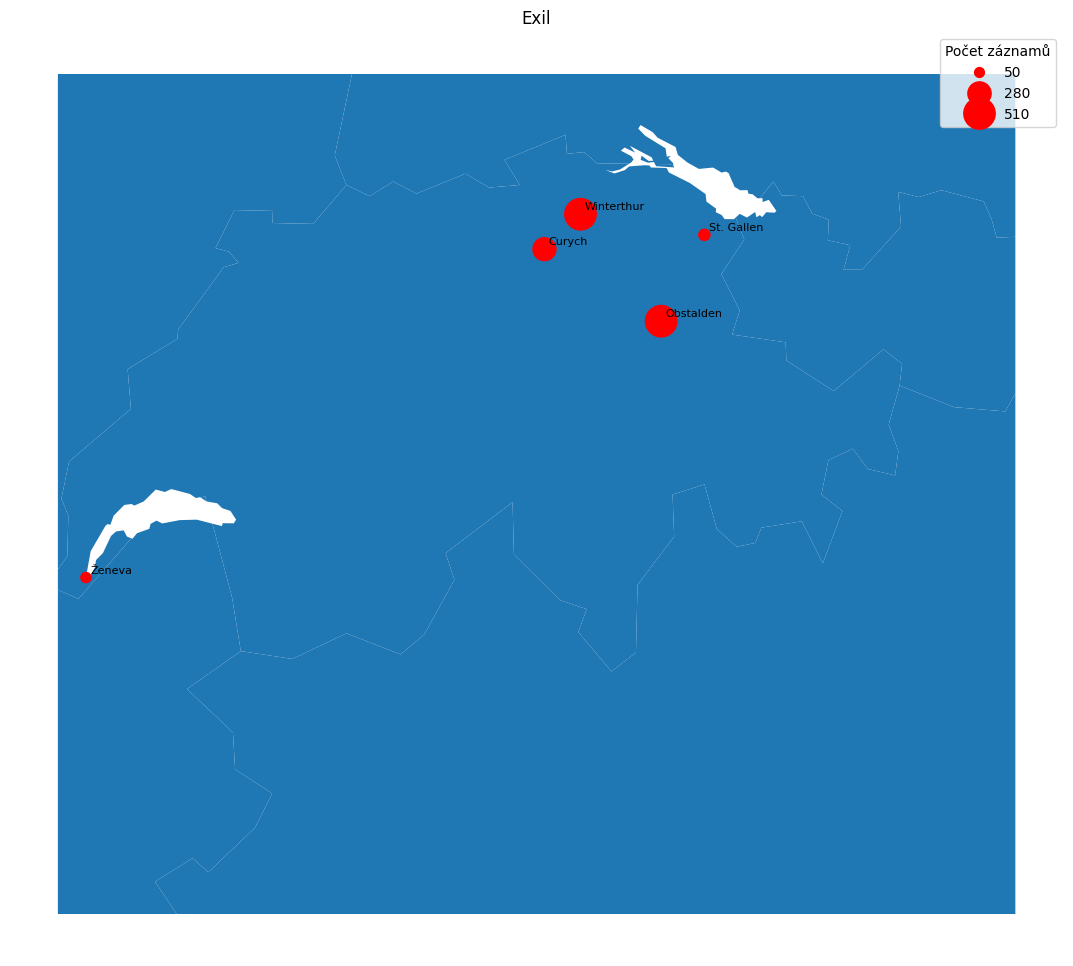

In [44]:
# Ze zemepisne sirky a vysky vytvorime body 
geometry = [Point(lon, lat) for lon, lat in zip(points_df['longitude'], points_df['latitude'])]

# Prevedeme DataFrame na GeoDataFrame
points_gdf = gpd.GeoDataFrame(points_df, geometry=geometry, crs="EPSG:4326") 

# Nacteni mapy 
base_map_data = gpd.read_file("data/geojson/world_1960.geojson")

# Nastaveni velikosti vykresleni
figsize = (15,12)

plt.figure(figsize=figsize)

# Ohraniceni mapy podle europe_and_north_america_bbox
ax = base_map_data.clip(bbox).plot(figsize=figsize)

# Parametr pro upravovani velikosti bodu
div = 1

# Parametr pro vypsani jmen mest do mapy
ann = True

# Vykresleni mist vydani
points_gdf.plot(figsize=figsize,
                ax=ax, 
                color = "red",
                marker = 'o',
                markersize=points_gdf['number of records'].apply(lambda x: x/div),  # Upraveni velikosti bodu 
                )

# Pokud nase promenna ann je nastavena na True, do mapy vypiseme i jmena mest 
if ann:
     # Pridame vypsani jmen mest do mapy
     for x, y, label in zip(points_df.longitude, points_df.latitude, points_df.city):
          ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize = 8)

# Tri moznosti legendy
point_sizes = [min(points_gdf['number of records'].apply(lambda x: int(round(x, -1)))), mean(points_gdf['number of records'].apply(lambda x: int(round(x, -1)))), max(points_gdf['number of records'].apply(lambda x: int(round(x, -1))))]

# Vytvoreni bodu pro legendu
legend_handles = [Line2D([], [], marker = 'o', lw=0, color='red', markersize=np.sqrt(size/div), label=str(int(round(size, -1)))) for size in point_sizes]

# Vykresleni legendy
ax.legend(handles=legend_handles, title='Počet záznamů', loc='upper right')

plt.title("Exil")
plt.grid(False)
ax.set_axis_off()  
plt.savefig("plots/exil_cropped_map.svg")
plt.show()

#### Alternativní vykreslení

In [ ]:
%%script echo skipping

%pip install altair
%pip install vl-convert-python
%pip install altair_saver



import altair as alt
alt.data_transformers.disable_max_rows()

url = "https://raw.githubusercontent.com/deldersveld/topojson/master/world-continents.json"
source = alt.topo_feature(url, "continent")


base = alt.Chart(source).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project(
    type = 'mercator',
#    scale= 350,                          # Magnify
#    center= [20,50],                     # [lon, lat]
#    clipExtent= [[0, 0], [400, 300]],    # [[left, top], [right, bottom]]
).properties(
    width=800,
    height=600
)

points = alt.Chart(df).mark_circle().encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    size=alt.Size('number of records:Q', title='pocet clanku'),
    tooltip='city:N',
    color=alt.value('red')
)
base+points
combined_chart = base+points
combined_chart.save('plots/map.png')

Couldn't find program: 'echo'
